In [31]:
import pandas as pd
import numpy as np
import json
import os
import evaluate
from datasets import Features, Dataset, ClassLabel, Sequence, Value, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForSeq2SeqLM
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

In [2]:
# set path for train/dev/test data
train_path = "./SubTask 1/MaSaC_train_erc.json"
val_path = "./SubTask 1/MaSaC_val_erc.json"
test_path = "./SubTask 1/MaSaC_test_erc.json"

In [3]:
# define the function to load JSON data
def load_JSON_data(data_path):
    '''
    argument: path of the data stored as JSON file
    read a JSON path containing training data and return their dataframe form that contains each utterances and their respective emotions.
    '''
    # Loading JSON data from path
    with open(data_path, 'r') as file:
        data_json = file.read()
        
    data = json.loads(data_json)
    
    # Creating new DF data for training
    df_list =[]
    for dialogue in data:
        for utterance, label in zip(dialogue["utterances"], dialogue["emotions"]):
            df_list.append({"utterances":utterance, "labels":label})
            
    df = pd.DataFrame(df_list)
    return df

In [37]:
# Creating Training and Validation data and test to see if they are in the right form
df_train = load_JSON_data(train_path)
df_val = load_JSON_data(val_path)
df_train.head()

,utterances,labels
0,kya kya bhar ke rakha hai indravadan ne is gha...,disgust
1,"ok, chalo rosesh chalo bahar",contempt
2,momma! hath chhodiye dad!,anger
3,dekho maya ya na bol raha hai! fir tum hi kaho...,neutral
4,"indravadan, tum kitne salo se ye joke maar rah...",neutral


<Axes: ylabel='count'>

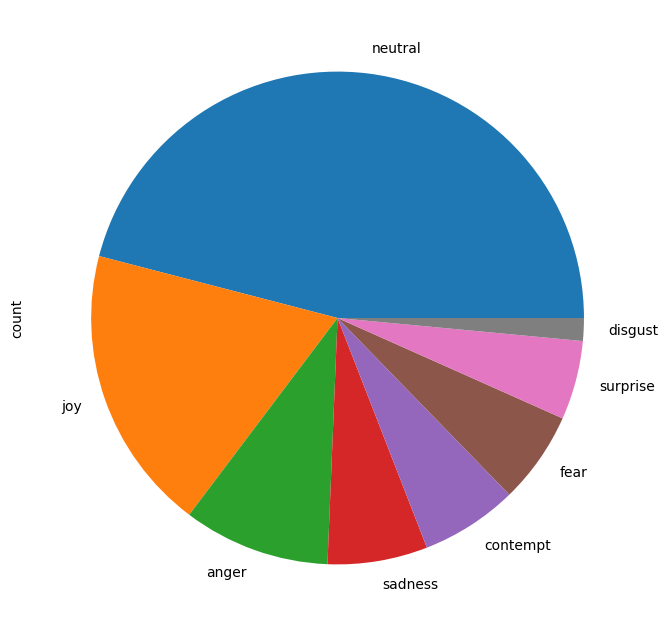

In [41]:
# Check if the train set is balanced
df_train.labels.value_counts().plot(kind='pie',figsize=(8,8))

In [5]:
# Creating id for each label
id2label = {0:'anger', 1:'contempt', 2:'disgust', 3:'fear', 4:'joy', 5:'neutral', 6:'sadness', 7:'surprise'}
label2id = {'anger':0, 'contempt':1, 'disgust':2, 'fear':3, 'joy':4, 'neutral':5, 'sadness':6, 'surprise':7}

In [6]:
# Set-up LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="all")

In [34]:
# Loading the Tokenizer and Model for fine-tuning

tokenizer = AutoTokenizer.from_pretrained("SoyGema/english-hindi")

num_labels = len(label2id)
model = AutoModelForSeq2SeqLM.from_pretrained(
    "SoyGema/english-hindi",
    num_labels = len(label2id),
    id2label=id2label,
    label2id=label2id)
'''model = get_peft_model(model, peft_config)'''
'''model.print_trainable_parameters()'''

'model.print_trainable_parameters()'

In [8]:
# Convert data from df to Huggingface dataset and tokenize it
def tokenize_data(raw_data):
    return tokenizer(raw_data["utterances"], padding="max_length", truncation=True, max_length=128)

# Specify the feature for dataset
emotion_labels = df_train['labels'].unique().tolist()

emotion_features = Features({'utterances':Value('string'),
                   'labels': ClassLabel(names=emotion_labels),})

# Covert the training data to HuggingFace Dataset
train_dataset = Dataset.from_pandas(df_train, features=emotion_features)
val_dataset = Dataset.from_pandas(df_val, features=emotion_features)

# Tokenize the data
tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/8506 [00:00<?, ? examples/s]

Map:   0%|          | 0/1354 [00:00<?, ? examples/s]

In [14]:
# Check the shape of the training dataset
print(tokenized_train_dataset)
print(tokenized_val_dataset)

Dataset({
    features: ['utterances', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 8506
})
Dataset({
    features: ['utterances', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1354
})


In [15]:
# Create the compute_metrics function according the the Shared Task's requirement
def compute_metrics(eval_pred):
    metric = evaluate.load('f1')
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references= labels, average = 'weighted')

In [22]:
# setup training parameters
training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

In [35]:
# begin training
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.419000,1.424081,0.468874
2,1.395300,1.406815,0.446064
3,1.364100,1.390629,0.475510
4,1.351500,1.395026,0.471395
5,1.278900,1.398676,0.475202


TrainOutput(global_step=5320, training_loss=1.3690804675109405, metrics={'train_runtime': 745.0722, 'train_samples_per_second': 57.082, 'train_steps_per_second': 7.14, 'total_flos': 1.0733751463305216e+16, 'train_loss': 1.3690804675109405, 'epoch': 5.0})

In [39]:
trainer.evaluate()

{'eval_loss': 1.3986756801605225,
 'eval_f1': 0.4752017300567137,
 'eval_runtime': 9.0038,
 'eval_samples_per_second': 150.38,
 'eval_steps_per_second': 18.881,
 'epoch': 5.0}

In [40]:
model.save_pretrained('./my_model')